In [18]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
import random
import time
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
# from torchsummary import summary


# Check assigned GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

# set manual seed for reproducibility
seed = 42

# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Mon Mar  6 20:55:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.216.04   Driver Version: 450.216.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:03:00.0  On |                  N/A |
| 40%   63C    P2    64W / 250W |   2297MiB / 11177MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:81:00.0 Off |                  N/A |
|  0%   

In [19]:
# create transforms
# We will just convert to tensor and normalize since no special transforms are mentioned in the paper
transforms_mnist = transforms.Compose([
                                         transforms.Resize(32),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.1307,), (0.3081,))
                                       ])

mnist_data_train = datasets.MNIST('./data/mnist/', train=True, download=True, transform=transforms_mnist)
mnist_data_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=transforms_mnist)

In [20]:
classes_mnist = np.array(list(mnist_data_train.class_to_idx.values()))
classes_test_mnist = np.array(list(mnist_data_test.class_to_idx.values()))
num_classes_mnist = len(classes_test_mnist)
print("Classes: {} \tType: {}".format(classes_mnist, type(classes_mnist)))
print("Classes Test: {} \tType: {}".format(classes_test_mnist, type(classes_mnist)))

Classes: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>
Classes Test: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>


In [21]:
print("Image Shape mnist: {}".format(mnist_data_train.data[0].shape))

Image Shape mnist: torch.Size([28, 28])


## Partitioning the Data (IID and non-IID)

In [22]:
def iid_partition(dataset, clients):
    
    num_items_per_client = int(len(dataset)/clients)
    client_dict = {}
    image_idxs = [i for i in range(len(dataset))]

    for i in range(clients):
        client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
        image_idxs = list(set(image_idxs) - client_dict[i])

    return client_dict

In [23]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client, dtype=None):
    
    shard_idxs = [i for i in range(total_shards)]
    client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
    idxs = np.arange(len(dataset))
    # print(len(idxs))
    if dtype == 'CIFAR10':
        data_labels = np.array(dataset.targets)
    elif dtype == 'MNIST':
        data_labels = dataset.targets.numpy()
    else:
        raise NotImplementedError

    # sort the labels
    label_idxs = np.vstack((idxs, data_labels))
    label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
    idxs = label_idxs[0,:]

    # divide the data into total_shards of size shards_size
    # assign num_shards_per_client to each client
    for i in range(clients):
        rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
        shard_idxs = list(set(shard_idxs) - rand_set)

        for rand in rand_set:
            client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
    return client_dict

In [24]:
class CustomDataset(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = list(idxs)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, label

## Models

In [25]:
class LeNet(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(400, 120)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(84, 10)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        out = self.sigmoid(x)
        return out

## Federated Averaging

### Local Training (Client Update)

In [26]:
class ClientUpdate(object):
    def __init__(self, dataset, batchSize, learning_rate, epochs, idxs):
        self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batchSize, shuffle=True)

        self.learning_rate = learning_rate
        self.epochs = epochs

    def train(self, model):

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)
        # optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)

        e_loss = []
        for epoch in range(1, self.epochs+1):

            train_loss = 0.0

            model.train()
            for data, labels in self.train_loader:

                if torch.cuda.is_available():
                    data, labels = data.cuda(), labels.cuda()

                # clear the gradients
                optimizer.zero_grad()
                # make a forward pass
                output = model(data)
                # calculate the loss
                loss = criterion(output, labels)
                # do a backwards pass
                loss.backward()
                # perform a single optimization step
                optimizer.step()
                # update training loss
                train_loss += loss.item()*data.size(0)

              # average losses
            train_loss = train_loss/len(self.train_loader.dataset)
            e_loss.append(train_loss)

        total_loss = sum(e_loss)/len(e_loss)

        return model.state_dict(), total_loss

### Server side training

In [27]:
def training(model, rounds, batch_size, lr, ds, data_dict, C, K, E, plt_title=None, plt_color=None):

  # global model weights
  global_weights = model.state_dict()

  # training loss
  train_loss, accuracies = [], []
  
  # measure time
  start = time.time()

  for curr_round in tqdm(range(1, rounds+1)):
    w, local_loss = [], []

    m = max(int(C*K), 1)
    
    S_t = np.random.choice(range(K), m, replace=False)
    for k in S_t:
      local_update = ClientUpdate(dataset=ds, batchSize=batch_size, learning_rate=lr, epochs=E, idxs=data_dict[k])
      weights, loss = local_update.train(model=copy.deepcopy(model))

      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))

    # updating the global weights
    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
      for i in range(1, len(w)):
        weights_avg[k] += w[i][k]

      weights_avg[k] = torch.div(weights_avg[k], len(w))

    global_weights = weights_avg

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    # accuracy = testing(model, )
    accuracies.append(testing(model, mnist_data_test, 128, nn.CrossEntropyLoss(), num_classes_mnist, classes_test_mnist))
    # print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    train_loss.append(loss_avg)

  end = time.time()
  print("Training Done!")
  print("Total time taken to Train: {}".format(end-start))
  
  return model, train_loss, accuracies

## Testing Loop

In [28]:
def testing(model, dataset, bs, criterion, num_classes, classes):
  #test loss 
  test_loss = 0.0
  correct_class = list(0. for i in range(num_classes))
  total_class = list(0. for i in range(num_classes))

  test_loader = DataLoader(dataset, batch_size=bs)
  l = len(test_loader)
  model.eval()
  for data, labels in test_loader:

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    #test accuracy for each object class
    for i in range(num_classes):
      label = labels.data[i]
      correct_class[label] += correct[i].item()
      total_class[label] += 1
    
  # avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  # print("Test Loss: {:.6f}\n".format(test_loss))

  # print test accuracy
  # for i in range(10):
  #   if total_class[i]>0:
  #     print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
  #           (classes[i], 100 * correct_class[i] / total_class[i],
  #           np.sum(correct_class[i]), np.sum(total_class[i])))
  #   else:
  #     print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  # print('\nFinal Test  Accuracy: {:.3f} ({}/{})'.format(
  #       100. * np.sum(correct_class) / np.sum(total_class),
  #       np.sum(correct_class), np.sum(total_class)))
  
  return 100. * np.sum(correct_class) / np.sum(total_class)

## mnist

In [29]:
rounds = 100
C = 0.1
K = 100
E = 5
lr=0.01

### Train (IID)

In [30]:
iid_dict = iid_partition(mnist_data_train, 100)
model_iid_b_10 = LeNet()
model_iid_b_30 = LeNet()
model_iid_b_60 = LeNet()

if torch.cuda.is_available():
    model_iid_b_10.cuda()
    model_iid_b_30.cuda()
    model_iid_b_60.cuda()

In [31]:
batch_size = 10
print("Training start, B = {}".format(batch_size))
mnist_iid_b_10, train_loss_iid_b_10, accuracy_iid_b_10 = training(model_iid_b_10, rounds, batch_size, lr, mnist_data_train, iid_dict, C, K, E)
print("----------------------")
print()

batch_size = 30
print("Training start, B = {}".format(batch_size))
mnist_iid_b_30, train_loss_iid_b_30, accuracy_iid_b_30 = training(model_iid_b_30, rounds, batch_size, lr, mnist_data_train, iid_dict, C, K, E)
print("----------------------")
print()

batch_size = 60
print("Training start, B = {}".format(batch_size))
mnist_iid_b_60, train_loss_iid_b_60, accuracy_iid_b_60 = training(model_iid_b_60, rounds, batch_size, lr, mnist_data_train, iid_dict, C, K, E)
print("----------------------")
print()

Training start, B = 10


100%|██████████| 100/100 [33:29<00:00, 20.09s/it]


Training Done!
Total time taken to Train: 2009.1714127063751
----------------------

Training start, B = 30


100%|██████████| 100/100 [22:39<00:00, 13.60s/it]


Training Done!
Total time taken to Train: 1359.6926820278168
----------------------

Training start, B = 60


100%|██████████| 100/100 [19:35<00:00, 11.75s/it]

Training Done!
Total time taken to Train: 1175.4596064090729
----------------------



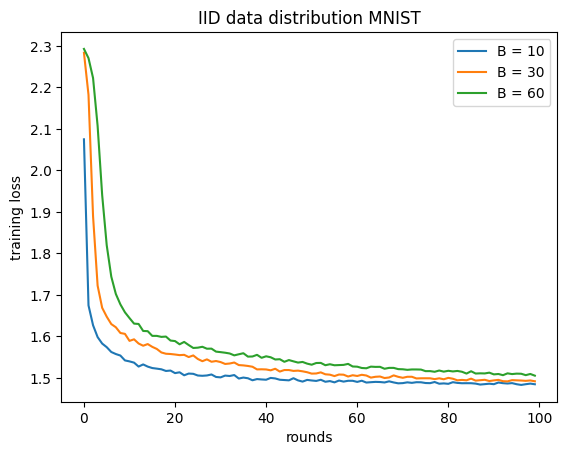

In [32]:
x = np.arange(rounds)
plt.plot(x, train_loss_iid_b_10, label="B = 10")
plt.plot(x, train_loss_iid_b_30, label="B = 30")
plt.plot(x, train_loss_iid_b_60, label="B = 60")
plt.title("IID data distribution MNIST")
plt.xlabel("rounds")
plt.ylabel("training loss")
plt.legend()
plt.show()

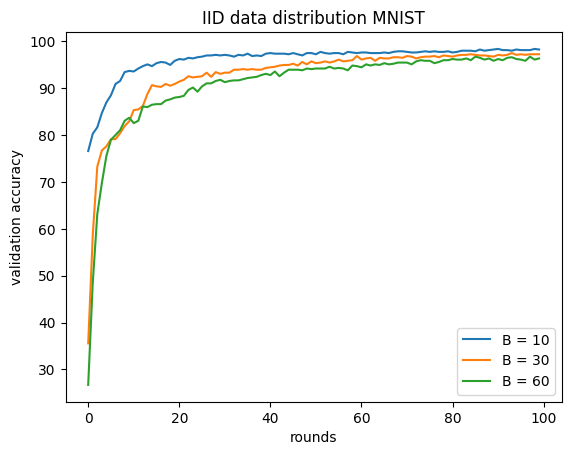

In [33]:
x = np.arange(rounds)
plt.plot(x, accuracy_iid_b_10, label="B = 10")
plt.plot(x, accuracy_iid_b_30, label="B = 30")
plt.plot(x, accuracy_iid_b_60, label="B = 60")
plt.title("IID data distribution MNIST")
plt.xlabel("rounds")
plt.ylabel("validation accuracy")
plt.legend()
plt.show()

### Test (IID)

In [34]:
criterion = nn.CrossEntropyLoss()

batch_size = 10
print("Testing for, B = {}".format(batch_size))
print(f"Final Test Accuracy: {testing(mnist_iid_b_10, mnist_data_test, 128, criterion, num_classes_mnist, classes_test_mnist)}")
print("----------------------")
print()

batch_size = 30
print("Testing for, B = {}".format(batch_size))
print(f"Final Test Accuracy: {testing(mnist_iid_b_30, mnist_data_test, 128, criterion, num_classes_mnist, classes_test_mnist)}")
print("----------------------")
print()

batch_size = 60
print("Testing for, B = {}".format(batch_size))
print(f"Final Test Accuracy: {testing(mnist_iid_b_60, mnist_data_test, 128, criterion, num_classes_mnist, classes_test_mnist)}")
print("----------------------")
print()

Testing for, B = 10
Final Test Accuracy: 98.22784810126582
----------------------

Testing for, B = 30
Final Test Accuracy: 97.21518987341773
----------------------

Testing for, B = 60
Final Test Accuracy: 96.32911392405063
----------------------



In [41]:
print(f"Maximum validation accuracy for B = 10 is: {max(accuracy_iid_b_10)}")
print(f"Maximum validation accuracy for B = 30 is: {max(accuracy_iid_b_30)}")
print(f"Maximum validation accuracy for B = 60 is: {max(accuracy_iid_b_60)}")

Maximum validation accuracy for B = 10 is: 98.35443037974683
Maximum validation accuracy for B = 30 is: 97.46835443037975
Maximum validation accuracy for B = 60 is: 96.70886075949367


### Train (Non IID)

In [35]:
non_iid_dict = non_iid_partition(mnist_data_train, 100, 200, 250, 2, 'MNIST')
model_non_iid_b_10 = LeNet()
model_non_iid_b_30 = LeNet()
model_non_iid_b_60 = LeNet()

if torch.cuda.is_available():
    model_non_iid_b_10.cuda()
    model_non_iid_b_30.cuda()
    model_non_iid_b_60.cuda()

In [36]:
batch_size = 10
print("Training start, B = {}".format(batch_size))
mnist_non_iid_b_10, train_loss_non_iid_b_10, accuracy_non_iid_b_10 = training(model_non_iid_b_10, rounds, batch_size, lr, mnist_data_train, non_iid_dict, C, K, E)
print("----------------------")
print()

batch_size = 30
print("Training start, B = {}".format(batch_size))
mnist_non_iid_b_30, train_loss_non_iid_b_30, accuracy_non_iid_b_30 = training(model_non_iid_b_30, rounds, batch_size, lr, mnist_data_train, non_iid_dict, C, K, E)
print("----------------------")
print()

batch_size = 60
print("Training start, B = {}".format(batch_size))
mnist_non_iid_b_60, train_loss_non_iid_b_60, accuracy_non_iid_b_60 = training(model_non_iid_b_60, rounds, batch_size, lr, mnist_data_train, non_iid_dict, C, K, E)
print("----------------------")
print()

Training start, B = 10


100%|██████████| 100/100 [28:37<00:00, 17.18s/it]


Training Done!
Total time taken to Train: 1717.7861061096191
----------------------

Training start, B = 30


100%|██████████| 100/100 [19:38<00:00, 11.79s/it]


Training Done!
Total time taken to Train: 1178.5822279453278
----------------------

Training start, B = 60


100%|██████████| 100/100 [17:12<00:00, 10.33s/it]

Training Done!
Total time taken to Train: 1032.7267158031464
----------------------



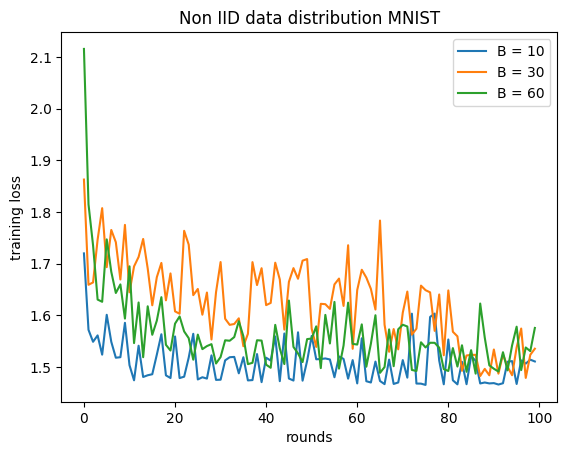

In [37]:
x = np.arange(rounds)
plt.plot(x, train_loss_non_iid_b_10, label="B = 10")
plt.plot(x, train_loss_non_iid_b_30, label="B = 30")
plt.plot(x, train_loss_non_iid_b_60, label="B = 60")
plt.title("Non IID data distribution MNIST")
plt.xlabel("rounds")
plt.ylabel("training loss")
plt.legend()
plt.show()

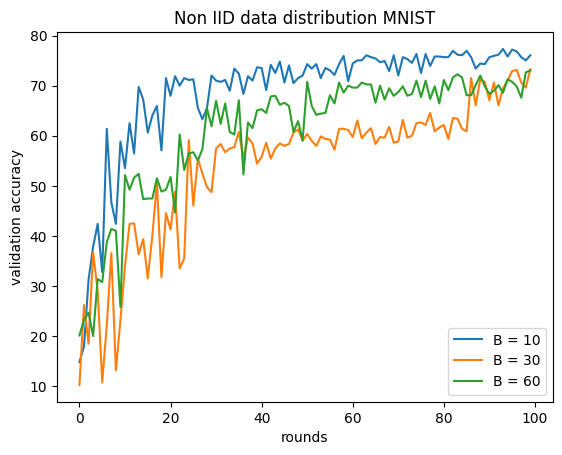

In [38]:
x = np.arange(rounds)
plt.plot(x, accuracy_non_iid_b_10, label="B = 10")
plt.plot(x, accuracy_non_iid_b_30, label="B = 30")
plt.plot(x, accuracy_non_iid_b_60, label="B = 60")
plt.title("Non IID data distribution MNIST")
plt.xlabel("rounds")
plt.ylabel("validation accuracy")
plt.legend()
plt.show()

### Test (Non IID)

In [39]:
criterion = nn.CrossEntropyLoss()

batch_size = 10
print("Testing for, B = {}".format(batch_size))
print(f"Final Test Accuracy: {testing(mnist_non_iid_b_10, mnist_data_test, 128, criterion, num_classes_mnist, classes_test_mnist)}")
print("----------------------")
print()

batch_size = 30
print("Testing for, B = {}".format(batch_size))
print(f"Final Test Accuracy: {testing(mnist_non_iid_b_30, mnist_data_test, 128, criterion, num_classes_mnist, classes_test_mnist)}")
print("----------------------")
print()

batch_size = 60
print("Testing for, B = {}".format(batch_size))
print(f"Final Test Accuracy: {testing(mnist_non_iid_b_60, mnist_data_test, 128, criterion, num_classes_mnist, classes_test_mnist)}")
print("----------------------")
print()

Testing for, B = 10
Final Test Accuracy: 76.07594936708861
----------------------

Testing for, B = 30
Final Test Accuracy: 73.29113924050633
----------------------

Testing for, B = 60
Final Test Accuracy: 73.0379746835443
----------------------



In [40]:
print(f"Maximum validation accuracy for B = 10 is: {max(accuracy_non_iid_b_10)}")
print(f"Maximum validation accuracy for B = 30 is: {max(accuracy_non_iid_b_30)}")
print(f"Maximum validation accuracy for B = 60 is: {max(accuracy_non_iid_b_60)}")

Maximum validation accuracy for B = 10 is: 77.34177215189874
Maximum validation accuracy for B = 30 is: 73.29113924050633
Maximum validation accuracy for B = 60 is: 73.0379746835443
